Nodes={'AC', 'AT', 'CG', 'GA', 'TA', 'GT'}
Edges=[('GT', 'TA'), ('TA', 'AC'), ('AC', 'CG'), ('CG', 'GT'), ('GT', 'TA'), ('TA', 'AC'), ('AC', 'CG'), ('CG', 'GA'), ('GA', 'AT')]


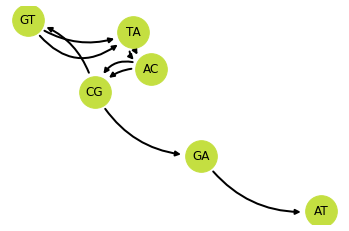

In [124]:
import networkx as nx
import matplotlib.pyplot as plt

def create_debruijn_graph(input_string, k):
    edges = []
    nodes = set()
    
    for i in range(len(input_string) - k + 1):
        node_a = input_string[i:(i + k - 1)]
        node_b = input_string[(i + 1):(i + k)]
        edges.append((node_a, node_b))
        nodes.add(node_a)
        nodes.add(node_b)
    
    return nodes, edges

nodes, edges = create_debruijn_graph('GTACGTACGAT', 3)
print(f'Nodes={nodes}\nEdges={edges}')

def visualize_debruijn_nxgraph(input_string, k):
    nodes, edges = create_debruijn_graph(input_string, k)
    G = nx.MultiDiGraph()
    G.add_edges_from(edges)

    pos = nx.spring_layout(G)
    green = '#C4DF41'
    blue = '#5EA1E1'
    
    nx.draw_networkx_nodes(G, pos, **{
        'node_color': green,
        'node_size':1000,
        'node_shape': 'o'
    })
    nx.draw_networkx_labels(G, pos)
    
    for edge in G.edges:
        nx.draw_networkx_edges(G, pos, **{
            'edgelist': [(edge[0],edge[1])],
            'width': 2,
            'arrowsize': 10,
            'min_target_margin': 20,
            'min_source_margin': 20,
            'connectionstyle': f'arc3,rad = {0.3 * (edge[2] + 1)}'
        })

    plt.axis('off')
    plt.show()
    return nodes, edges
    

G = visualize_debruijn_nxgraph('GTACGTACGAT', 3)

In [66]:
class DeBruijnGraph:
    """ A de Bruijn multigraph built from a collection of strings.
        User supplies strings and k-mer length k.  Nodes of the de
        Bruijn graph are k-1-mers and edges correspond to the k-mer
        that joins a left k-1-mer to a right k-1-mer. """

    @staticmethod
    def chop(st, k):
        """ Chop a string up into k mers of given length """
        for i in range(0, len(st)-(k-1)):
            yield (st[i:i+k], st[i:i+k-1], st[i+1:i+k])
    
    class Node:
        """ Node in a de Bruijn graph, representing a k-1 mer.  We keep
            track of # of incoming/outgoing edges so it's easy to check
            for balanced, semi-balanced. """
        
        def __init__(self, km1mer):
            self.km1mer = km1mer
            self.nin = 0
            self.nout = 0
        
        def isSemiBalanced(self):
            return abs(self.nin - self.nout) == 1
        
        def isBalanced(self):
            return self.nin == self.nout
        
        def __hash__(self):
            return hash(self.km1mer)
        
        def __str__(self):
            return self.km1mer
    
    def __init__(self, reads, k):
        """ Build de Bruijn multigraph given string iterator and k-mer
            length k """
        self.G = {}     # multimap from nodes to neighbors
        self.nodes = {} # maps k-1-mers to Node objects
        for st in reads:
            for kmer, km1L, km1R in self.chop(st, k):
                nodeL, nodeR = None, None
                if km1L in self.nodes:
                    nodeL = self.nodes[km1L]
                else:
                    nodeL = self.nodes[km1L] = self.Node(km1L)
                if km1R in self.nodes:
                    nodeR = self.nodes[km1R]
                else:
                    nodeR = self.nodes[km1R] = self.Node(km1R)
                nodeL.nout += 1
                nodeR.nin += 1
                self.G.setdefault(nodeL, []).append(nodeR)
        
        # Iterate through nodes and tally how many are balanced,
        # semi-balanced, or neither
        self.nsemi, self.nbal, self.nneither = 0, 0, 0
        
        # Keep track of head and tail nodes in the case of a graph with
        # Eularian path (not cycle)
        self.head, self.tail = None, None
        for node in self.nodes.values():
            if node.isBalanced():
                self.nbal += 1
            elif node.isSemiBalanced():
                if node.nin == node.nout + 1:
                    self.tail = node
                if node.nin == node.nout - 1:
                    self.head = node
                self.nsemi += 1
            else:
                self.nneither += 1
    
    def nnodes(self):
        """ Return # nodes """
        return len(self.nodes)
    
    def nedges(self):
        """ Return # edges """
        return len(self.G)
    
    def hasEulerianPath(self):
        """ Return true iff graph has Eulerian path. """
        return self.nneither == 0 and self.nsemi == 2
    
    def hasEulerianCycle(self):
        """ Return true iff graph has Eulerian cycle. """
        return self.nneither == 0 and self.nsemi == 0
    
    def isEulerian(self):
        """ Return true iff graph has Eulerian path or cycle """
        return self.hasEulerianPath() or self.hasEulerianCycle()
    
    def eulerianPath(self):
        """ Find and return Eulerian path or cycle (as appropriate) """
        assert self.isEulerian()
        g = self.G
        if self.hasEulerianPath():
            g = g.copy()
            assert self.head is not None
            assert self.tail is not None
            g.setdefault(self.tail, []).append(self.head)
        # graph g has an Eulerian cycle
        tour = []
        src = next(iter(g.keys())) # pick arbitrary starting node
        
        def __visit(n):
            while len(g[n]) > 0:
                dst = g[n].pop()
                __visit(dst)
            tour.append(n)
        
        __visit(src)
        tour = tour[::-1][:-1]
            
        if self.hasEulerianPath():
            # Adjust node list so that it starts at head and ends at tail
            sti = tour.index(self.head)
            tour = tour[sti:] + tour[:sti]
        
        # Return node list
        return [str(t) for t in tour]
        
    def toDot(self, dotFh, weights=False):
        """ Write dot representation to given filehandle.  If 'weights'
            is true, label edges corresponding to distinct k-1-mers
            with weights, instead of writing a separate edge for each
            copy of a k-1-mer. """
        dotFh.write("digraph \"Graph\" {\n")
        dotFh.write("  bgcolor=\"transparent\";\n")
        for node in self.G.keys():
            lab = node.km1mer
            dotFh.write("  %s [label=\"%s\"] ;\n" % (lab, lab))
        for src, dsts in self.G.items():
            srclab = src.km1mer
            if weights:
                weightmap = {}
                if weights:
                    for dst in dsts:
                        weightmap[dst] = weightmap.get(dst, 0) + 1
                for dst, v in weightmap.iteritems():
                    dstlab = dst.km1mer
                    dotFh.write("  %s -> %s [label=\"%d\"] ;\n" % (srclab, dstlab, v))
            else:
                for dst in dsts:
                    srclab = src.km1mer
                    dstlab = dst.km1mer
                    dotFh.write("  %s -> %s [label=\"\"] ;\n" % (srclab, dstlab))
        dotFh.write("}\n")

input_string = 'GTACGTACGAT'
k = 6
# reads = create_kmers(input_string, k)
reads = [input_string]
G = DeBruijnGraph(reads, k)

In [67]:
path = G.eulerianPath()
print(path)
output_string = path[0][:-1]
for node in path:
    output_string += node[-1:]
print(output_string)

['GTACG', 'TACGA', 'ACGAT', 'GTACG', 'TACGT', 'ACGTA', 'CGTAC']
GTACGATGTAC


In [68]:
def graph():
    with open('dbg.dot', 'wt') as f:
        G.toDot(f)
    with open('dbg.dot', 'rt') as f:
        dotfile = f.read()
    return dotfile

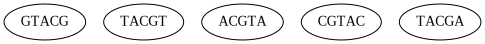

In [69]:
# %load_ext gvmagic
%dotstr graph()

In [44]:
def get_eulerian_path(G):
    

In [71]:
def eulerianPath(self):
    """ Find and return Eulerian path or cycle (as appropriate) """
    g = g.copy()
    assert self.head is not None
    assert self.tail is not None
    g.setdefault(self.tail, []).append(self.head)
    # graph g has an Eulerian cycle
    tour = []
    src = next(iter(g.keys())) # pick arbitrary starting node

    def __visit(n):
        while len(g[n]) > 0:
            dst = g[n].pop()
            __visit(dst)
        tour.append(n)

    __visit(src)
    tour = tour[::-1][:-1]

    if self.hasEulerianPath():
        # Adjust node list so that it starts at head and ends at tail
        sti = tour.index(self.head)
        tour = tour[sti:] + tour[:sti]

    # Return node list
    return [str(t) for t in tour]

OutMultiEdgeView([('GT', 'TA', 0), ('GT', 'TA', 1), ('TA', 'AC', 0), ('TA', 'AC', 1), ('AC', 'CG', 0), ('AC', 'CG', 1), ('CG', 'GT', 0), ('CG', 'GA', 0), ('GA', 'AT', 0)])

In [79]:
input_string = 'GTACGTACGAT'
k = 6

# reads = create_kmers(input_string, k)
reads = [input_string]
G = create_debruijn_graph(input_string, k)

In [111]:
nodes, edges = G
graph = {node: set() for node in nodes}
balances = {node: 0 for node in nodes}

for a, b in edges:
    graph[a].add(b)

    # out edge
    balances[a] += 1
    # in edge
    balances[b] -= 1
    
print(balances)

{'GTACG': 1, 'ACGAT': -1, 'ACGTA': 0, 'TACGT': 0, 'TACGA': 0, 'CGTAC': 0}


In [114]:
source = [node for node, balance in balances.items() if balance > 0][0]
print(source)

['GTACG']


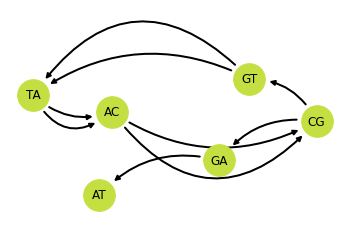

'GTACGAT'

In [126]:
# Shortest Common Superstring using deBruijn Graph 

def scs_dbg(input_string, k):
    # G = create_debruijn_graph(input_string, k)
    G = visualize_debruijn_nxgraph(input_string, k)
    return eulerian_walk(G)

def eulerian_walk(G):
    nodes, edges = G
    graph = {node: set() for node in nodes}
    balances = {node: 0 for node in nodes}

    for a, b in edges:
        graph[a].add(b)

        # out edge
        balances[a] += 1
        # in edge
        balances[b] -= 1
    
    # Find first Node, source with out > in
    source = [n for n, b in balances.items() if b > 0][0]
    
    # Use breadth-first search 
    nodes_path = bfs(graph, source)
    return glue_path(nodes_path)
    
def bfs(graph, node):
    # Find shortest path
    path = []
    visited = [node]
    queue = [node]

    while queue:
        s = queue.pop(0) 
        path.append(s)

        for neighbour in graph[s]:
            if neighbour not in visited:
                visited.append(neighbour)
                queue.append(neighbour)
    return path

def glue_path(ss):
    sup = ss[0]
    for i in range(len(ss) - 1):
        sup += ss[i+1][-1:]
    return sup

scs_dbg('GTACGTACGAT', 3)

In [93]:
# Find maximum overlap bewteen adjacent reads
def max_overlap(a, b, min_length=3):
    start = 0
    while True:
        start = a.find(b[:min_length], start)
        if start == -1:
            return 0
        if b.startswith(a[start:]):
            return len(a) - start
        start += 1

# Find the shortest common superstring on all sorted permutations        
def scs(ss):
    shortest_sup = None
    sup = ss[0]
    for i in range(len(ss) - 1):
        overlap_len = max_overlap(ss[i], ss[i+1], min_length=1)
        sup += ss[i+1][overlap_len:]
    if not shortest_sup or len(sup) < len(shortest_sup):
        shortest_sup = sup
    return shortest_sup

output_string = scs(reads)
output_string

'GTACGTACGAT'

In [91]:
# Utils
def create_kmers(input_string, k):
    kmers = []
    for i in range(len(input_string) - k):
        kmers.append(input_string[i:(i + k)])
    kmers.append(input_string[-k:])
    return kmers    

reads = create_kmers('GTACGTACGAT', 6)

for i, read in enumerate(reads):
    print(f'{i * " "}{read}')


GTACGT
 TACGTA
  ACGTAC
   CGTACG
    GTACGA
     TACGAT


In [106]:
seq = '''gcaggcggatcacgaggttgggagatcgagaccatcctggctaacggtga
aaccccgtctctactgaaaaatacaaaaaaaaattagccgggcgtggtgc
tgggcacctgtagtcccagctactcgggaggctgaggaaggagaatggcg
tgaacctgggcggtggagcttgcagtgagctgagatcacgccactgcact
ccagcctgggcgacagagcgagattccatctcaaaaaaaaaaaaaaaagg
cctcccctgcttgccacaggtctccccaaggcgcactggcctcatcttgg
gcctgtgttatctcctaggttggctctgactgtaccaccatccactacaa
ctacatgtgtaacagttcctgcatgggcggcatgaaccggaggcccatcc
tcaccatcatcacactggaagactccaggtcaggagccacttgccaccct
gcacactggcctgctgtgccccagcctctgcttgcctctgacccctgggc
ccacctcttaccgatttcttccatactactacccatccacctctcatcac
atccccggcggggaatctccttactgctcccactcagttttcttttctct
ggctttgggacctcttaacctgtggcttctcctccacctacctggagctg
gagcttaggctccagaaaggacaagggtggttgggagtagatggagcctg
gttttttaaatgggacaggtaggacctgatttccttactgcctcttgctt
ctcttttcctatcctgagtagtggtaatctactgggacggaacagctttg
aggtgcgtgtttgtgcctgtcctgggagagaccggcgcacagaggaagag
aatctccgcaagaaaggggagcctcaccacgagctgcccccagggagcac
taagcgaggtaagcaagcaggacaagaagcggtggaggagaccaagggtg
cagttatgcctcagattcacttttatcacctttccttgcctctttcctag
cactgcccaacaacaccagctcctctccccagccaaagaagaaaccactg
gatggagaatatttcacccttcaggtactaagtcttgggacctcttatca
agtggaaagtttccagtctaacactcaaaatgccgttttcttcttgactg
ttttacctgcaattggggcatttgccatcagggggcagtgatgcctcaaa
gacaatggctcctggttgtagctaactaacttcagaacaccaacttatac
cataatatatattttaaaggaccagaccagctttcaaaaagaaaattgtt
aaagagagcatgaaaatggttctatgactttgcctgatacagatgctact
tgacttacgatggtgttacttcctgataaactcgtcgtaagttgaaaata
ttgtaagttgaaaatggatttaatacacctaatctaaggaacatcatagc
ttagcctagcctgctttttttttttttttttttggagacagagtctcact
ctgtcacccaggctggagtgcagtggcgggatctcggctcactgcaacct
ccgccttctgggttcaagcgattctcctgcctcagcccactgagtagctg
ggattacaggcacctgccccgacgcccagctaattttttgttatttattt
atttttttttttagtagagatgaggtttcaccatgttggccaggctagtc
tcgaactcctgaccttgtgatctgcctgccttggcctcccaaagtgctgg
gattacaggcgtgagccaccgcacccggcctgcctagcctacttttattt
tatttttaatggagacagcatcttgctctgttgcccaggctggattacag
tgatgtgatcatagctcattataccctcctgggctcaagcaatcccccta
actctgcctccccagtagctaggaccacaggcatacaccaccatacccag
ctaatttttaaaattttttgtagatagatagagtctcactatgttgccca
ggctggtctctagcctacttttttgagacaaggtcttgctctgtcaccca
ggctggatagagtgcagtagtgcagtcacagctcactgcagcctccacct
cccaggctccatccatcctcccagctcagcctcccaagttgcttcaacta
caggcctgcaccaccatgcctggctaatttttatttatttatttttattt
tattttattttatttttttgagactcagtctcactctgtcgcccaggctg
gagtgcagtggcatgatctcggctcactgcaacctctgcctcctgggttc
aagtgattctcctgcctcagcctcccgaatagctaggactacaagcgcct
gctaccacgcccagctaatttttgtatttttagtagagacagggtttcac
catgttggccaggctggtctcgaacttctgaccatgtgatccgcccgcct
cggcctcccaaagtgctgggattacaggtgtgagccaccacgcccggcta
atttttatttatttatttaaagacagagtctcactctgtcactcaggcta
gagtgcagtggcaccatctcagctcactgcagccttgacctccctgggct
ccggtgatttcaccctcccaagtagctaggactacaggcacatgccacga
cacccagctaattttttattttctgtgaagtcaaggtcttgctacgttgc
ccatgctggtatcaaacccctgggctcaatcaatccttccacctcagcct
ccccaagtattggggttacaggcatgagctaccacactcagccctagcct
acttgaaacgtgttcagagcatttaagttaccctacagttgggcaaagtc
atctaacacaaagccctttttatagtaataaaatgttgtatatctcatgt
gatttattgaatattgttactgaaagtgagaaacagcatggttgcatgaa
aggaggcacagtcgagccaggcacagcctgggcgcagagcgagactcaaa
aaaagaaaaggccaggcgcactggctcacgcctgtaatcccagcatttcg
ggaggctgaggcgggtggatcacctgaggtcaggagttcaagaccagcct
agccaacatggtgaaaccccgtctctactaaaatacaaaaattaaccggg
cgtgatggcaggtgcctgtaatcccagctacttgggaggctgaggcagga
gaatcgcttgaaccaggaggcggaggttgcagggagccaagatggcgcca
ctgcactccagcctgggcgatagagtgagactccgtctcagaaaaaaaag
aaaagaaacgaggcacagtcgcatgcacatgtagtcccagttacttgaga
ggctaaggcaggaggatctcttgagcccaagagtttgagtccagcctgaa
caacatagcaagacatcatctctaaaatttaaaaaagggccgggcacagt
ggctcacacctgtaatcccagcactttgggaggtggaggtgggtagatca
cctgacgtcaggagttggaaaccagcctggctaacatggtgaagccccat
ctctactaaaaacacaaaaattagccaggtgtggtagcacacgcctgtag
tcccagctactcgggaggctgaggcacaagaatcacttgaaccccagagg
cggagattgcaatcagccaagattgcaccattgcactcccgcctgggcaa
cagagtgagaccccatctcaaaataaataaataaatatttttaaaagtca
gctgtataggtacttgaagtgcagtttctactaaatgcatgttgcttttg
taccgtcataaagtcaaacaattgtaacttgaaccatcttttaactcagg
tactgtgtatatacttacttctccccctcctctgttgctgcagatccgtg
ggcgtgagcgcttcgagatgttccgagagctgaatgaggccttggaactc
aaggatgcccaggctgggaaggagccaggggggagcagggctcactccag
gtgagtgacctcagccccttcctggccctactcccctgccttcctaggtt
ggaaagccataggattccattctcatcctgccttcatggtcaaaggcagc
tgaccccatctcattgggtcccagccctgcacagacatttttttagtctt
cctccggttgaatcctataaccacattcttgcctcagtgtatccacagaa
catccaaacccagggacgagtgtggatacttctttgccattctccgcaac
tcccagcccagagctggagggtctcaaggaggggcctaataattgtgtaa
tactgaatacagccagagtttcaggtcatatactcagccctgccatgcac
cggcaggtcctaggtgacccccgtcaaactcagtttccttatatataaaa
tggggtaagggggccgggcgcagtggctcacgaatcccacactctgggag
gccaaggcgagtggatcacctgaggtcgggagtttgagcccagcctgacc
aacatggagaaaccccatctctactaaaaatacaaaagtagccgggcgtg
gtgatgcatgcctgtaatcccagctacctactcgggaggctgaggcagga
gaatcgcttgaacccgggaggcagaggttgcggtgagctgagatctcacc
attacactccagcctgggcaacaagagtgaaactccgtctcaaaaaagat
aaataaagtaaaatggggtaagggaagattacgagactaatacacactaa
tactctgaggtgctcagtaaacatatttgcatggggtgtggccaccatct
tgatttgaattcccgttgtcccagccttaggcccttcaaagcattggtca
gggaaaaggggcacagaccctctcactcatgtgatgtcatctctcctccc
tgcttctgtctcctacagccacctgaagtccaaaaagggtcagtctacct
cccgccataaaaaactcatgttcaagacagaagggcctgactcagactga
cattctccacttcttgttccccactgacagcctcccacccccatctctcc
ctcccctgccattttgggttttgggtctttgaacccttgcttgcaatagg
tgtgcgtcagaagcacccaggacttccatttgctttgtcccggggctcca
ctgaacaagttggcctgcactggtgttttgttgtggggaggaggatgggg
agtaggacataccagcttagattttaaggtttttactgtgagggatgttt
gggagatgtaagaaatgttcttgcagttaagggttagtttacaatcagcc
acattctaggtaggggcccacttcaccgtactaaccagggaagctgtccc
tcactgttgaattttctctaacttcaaggcccatatctgtgaaatgctgg
catttgcacctacctcacagagtgcattgtgagggttaatgaaataatgt
acatctggccttgaaaccaccttttattacatggggtctagaacttgacc
cccttgagggtgcttgttccctctccctgttggtcggtgggttggtagtt
tctacagttgggcagctggttaggtagagggagttgtcaagtctctgctg
gcccagccaaaccctgtctgacaacctcttggtgaaccttagtacctaaa
aggaaatctcaccccatcccacaccctggaggatttcatctcttgtatat
gatgatctggatccaccaagacttgttttatgctcagggtcaatttcttt
tttcttttttttttttttttttctttttctttgagactgggtctcgcttt
gttgcccaggctggagtggagtggcgtgatcttggcttactgcagccttt
gcctccccggctcgagcagtcctgcctcagcctccggagtagctgggacc
acaggttcatgccaccatggccagccaacttttgcatgttttgtagagat
ggggtctcacagtgttgcccaggctggtctcaaactcctgggctcaggcg
atccacctgtctcagcctcccagagtgctgggattacaattgtgagccac
cacgtccagctggaagggtcaacatcttttacattctgcaagcacatctg
cattttcaccccacccttcccctccttctccctttttatatcccattttt
atatcgatctcttattttacaataaaactttgctgccacctgtgtgtctg
aggggtgaacgccagtgcaggctactggggtcagcaggtgcaggggtgag
tgaggaggtgctgggaagcagccacctgagtctgcaatgagtgtgggctg
gggggcccagtgcccgggttccgggaggggaacaaaggctggagactggg
tcagtctgcgggctgcatgacaacaagggagggggtggctccattcataa
ctcaggaaccaaccgtccctcctcccctccggccacggctggcacaaggt
tctctccctcccctgcttctaggactgggctgcttccccctcggcagcct
ctcaccaaggattacgggatttaaatgtctgatttagcaaggctgagcct
ccagggtggccatctgctccatcagaaagtggcaggatacctgggttccc
aaggggaacaggggtgggtgctactggatggagagaggccagtgggaggc
ctgctagccagggtcccaggaaagtgggggcagctaaggtaagagtaggg
gtgtggggctaggtccttcccagcatcccctcatcctgggcctcatgcca
ggtagctgaatgaattgaagctttaaactctgccaggaaaacctttcaaa
gggcttcttgggatagggaggagagtcgggttgaggagctcagtactgcc
tgcccatgctcctcagggctgctggctcccagggaggggggctgggagca
ggcaggctcttccccatcacccactgctctcttggagccagtgcttgaag
gggcagtcagacatggcttgcccttcctcctccctggtggtggagatggg
tgttagggtccagtgggtgctactgtccaggggggcttctggggccacca
gcctgtcagctcatcaaccaggctgaaggtgcaagcaggagccccttgcc
ttgccccaaggatcccagacagctatgaagccaccagccttcctgacctc
aagaccaccttttttttttctctttcttactagggaatgccaaacactct
ccccagg'''

len(seq.replace('\n', ''))

7207

In [107]:
10304

102500